In [ ]:
!nvidia-smi

Mon Aug  3 20:36:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 9.2MB/s 
     |████████████████████████████████| 1.1MB 39.4MB/s 
     |████████████████████████████████| 890kB 64.2MB/s 
     |████████████████████████████████| 3.0MB 56.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0f3a99395c42df7ea29f7ad7f3505291d5ba1256b30f635f254d036a9acd1c2d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 8.3MB/s 


In [ ]:
!pip install ujson

     |████████████████████████████████| 184kB 8.7MB/s 


In [ ]:
#!pip install pyspellchecker

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!unzip -q "/content/gdrive/My Drive/Yelp_Sentiment_Analysis/dataset.zip" -d '/content'

**Fetch data and Preprocess**

In [ ]:
import random
import numpy as np
import json
from collections import Counter
from tqdm import tqdm
import spacy
import re
from transformers import BertTokenizer, BertModel
import seaborn as sns
#from spellchecker import SpellChecker

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def word_tokenize(sent):
    doc = nlp(sent)
    return [token.text for token in doc]

In [ ]:
# does data cleaning for inital text
def process_file(filename, data_type):
    print(f"Pre-processing {data_type} examples...")
    examples = {}
    total = 0

    with open(filename, "r") as fh:
        source = json.load(fh)
        total = len(source)

    for idx in tqdm(range(total)):
        text = source[str(idx)]["text"]
        # basic text preprocessing
        text = text.replace("''", '" ').replace("``", '" ')  # replace the quotes 
        text = text.replace("`", "'") # backticks typo
        text = text.replace("\"", "") # replace quotes
        text = text.replace("...", " ").replace(". . .", " ").replace('..', ' ') # replace dots
        text = text.replace("\n", " ") # replace new line chars
        text = re.sub(r'(?:http:|https:).*?(?=\s)', '', text)  # remove url and website
        text = re.sub(r'www.*?(?=\s)', '', text)  # remove url and website

        list_to_replace = [':(', '=)', ':)', ':P', '-', ',,', ':', ';', '/', '+', '~', '_', '*', '(', ')', '&', '=', '@'] #replace the punctuations which are messy with empty
        for elem in list_to_replace:
            text = text.replace(elem, '')
        
        text = re.sub(r'\!{2,}', '!', text) # duplicate punctuatio
        text = re.sub(r'\?{2,}', '?', text) # duplicate punctuation
        text = text.replace('?!', '?').replace('!?', '?') #replace slang punctuation with question
        text = re.sub(r'\s(?:\.|\,)', '', text) # replace spaces before punctuation
        text = re.sub(r'([a-zA-Z?!])\1\1+', r'\1', text) # removes repeated characters (Ex: Veryyyyy -> very)
        
        text = re.sub(r'\s{2,}', ' ', text) # replace multiple spaces
        text = text.strip() # strips spaces

        text = text.lower() # lower text

        ## Edit spell distance Too Slow
        # context_token = word_tokenize(text)

        # # edit spell distance
        # spell = SpellChecker() # default distance = 2
        # misspelled = spell.unknown(context_token)
        # idx_correction = []
        # correction = []

        # # iterate misspelled
        # for word in misspelled:
        #     idx_correction.append(context_token.index(word))
        #     correction.append(spell.correction(word))
        
        # # replace 
        # for i, id in enumerate(idx_correction):
        #     context_token[id] = correction[i]

        # sep = ' '
        # final_text = sep.join(context_token) 
        # text = re.sub(r'\s(?:\.|\,|\?|\$|\!|\'s|n\'t|\'re|\'ve|\'m)', '', final_text) # replace spaces before punctuation

        examples[str(idx)] = {"user_id": source[str(idx)]["user_id"], 
                              "business_id": source[str(idx)]["business_id"], 
                              "text": text,
                              "rating": source[str(idx)]["rating"]}

    return examples

In [ ]:
#nlp = spacy.blank("en")

train_examples = process_file('dataset/train.json', "train")
test_examples = process_file('dataset/test.json', "test")
train_examples_small = process_file('dataset/train_small.json', "train")
test_examples_small = process_file('dataset/test_small.json', "test")

Pre-processing train examples...


 10%|▉         | 999/10000 [00:00<00:00, 9982.16it/s]

Pre-processing test examples...


 10%|▉         | 992/10000 [00:00<00:00, 9919.56it/s]

Pre-processing train examples...


100%|██████████| 1000/1000 [00:00<00:00, 9547.00it/s]

Pre-processing test examples...


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Key Tokens
print('[CLS] token: ', tokenizer.convert_tokens_to_ids("[CLS]"))
print('[SEP] token: ', tokenizer.convert_tokens_to_ids("[SEP]"))
print('[PAD] token: ', tokenizer.convert_tokens_to_ids("[PAD]"))

[CLS] token:  101
[SEP] token:  102
[PAD] token:  0


In [ ]:
def pad_sent(dataset, max_text_len = 350):  #token number 0 is [PAD]
    text = []
    attnmask = []
    seg_id = []
    rating = []
    uniq_ids = []
    text_len = []

    for idx in tqdm(dataset):
        uniq_ids.append(int(idx))  # append unique ids
        curr_text = dataset[str(idx)]["text"] # extract text
        curr_text = "[CLS] " + curr_text  # add starting cls token
        tokenized_text = tokenizer.tokenize(curr_text) # tokenize            
        tokenized_ids = tokenizer.convert_tokens_to_ids(tokenized_text) # convert to ids

        # add text length
        text_len.append(len(tokenized_ids))

        tokenized_ids = tokenized_ids[:max_text_len - 1]   # trim the reviews
        tokenized_ids.append(102) # add special token for [SEP]

        curr_sent_len = len(tokenized_ids)
        remaining = max_text_len - curr_sent_len # words remaining for padding

        # pad the input token
        tokenized_ids.extend([0] * remaining)  # pad the text to max_text_len
        # add to storage
        text.append(tokenized_ids)
        
        # create attention and segmented mask
        curr_attn = [1] * curr_sent_len  
        curr_attn.extend([0] * remaining)
        curr_seg_id = [0] * max_text_len

        # append to storage
        attnmask.append(curr_attn)
        seg_id.append(curr_seg_id)
        rating.append(dataset[str(idx)]["rating"])


    return text, attnmask, seg_id, rating, uniq_ids, text_len

In [ ]:
text, attnmask, seg_id, rating, uniq_ids, text_len = pad_sent(train_examples)

100%|██████████| 90000/90000 [03:02<00:00, 492.52it/s]


% under 350:  88.14777777777778 %


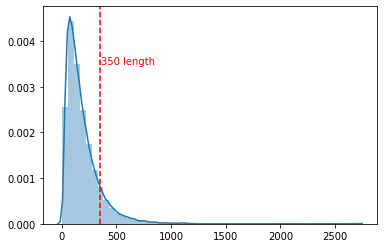

In [ ]:
ax = sns.distplot(text_len)
ax.axvline(350, color='red', linestyle = '--')
ax.text(355, 0.0035, '350 length', color = 'red');
sum_under_350 = [1 if elem < 350 else 0 for elem in text_len]
print('% under 350: ', np.sum(sum_under_350) * 100/ len(sum_under_350), '%')

In [ ]:
np.savez('/content/gdrive/My Drive/Yelp_Sentiment_Analysis/train.npz',
         text = np.array(text),
         attnmask = np.array(attnmask),
         seg_id = np.array(seg_id),
         rating = np.array(rating),
         ids = np.array(uniq_ids)
)

In [ ]:
text, attnmask, seg_id, rating, uniq_ids, text_len = pad_sent(test_examples)

100%|██████████| 10000/10000 [00:21<00:00, 462.87it/s]


% under 350:  88.87 %


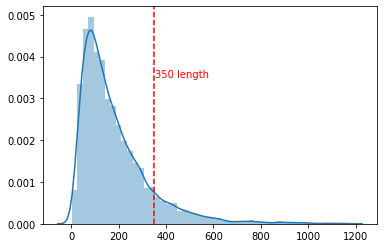

In [ ]:
ax = sns.distplot(text_len)
ax.axvline(350, color='red', linestyle = '--')
ax.text(355, 0.0035, '350 length', color = 'red');
sum_under_350 = [1 if elem < 350 else 0 for elem in text_len]
print('% under 350: ', np.sum(sum_under_350) * 100/ len(sum_under_350), '%')

In [ ]:
np.savez('/content/gdrive/My Drive/Yelp_Sentiment_Analysis/test.npz',
         text = np.array(text),
         attnmask = np.array(attnmask),
         seg_id = np.array(seg_id),
         rating = np.array(rating),
         ids = np.array(uniq_ids)
)

In [ ]:
text, attnmask, seg_id, rating, uniq_ids, text_len = pad_sent(train_examples_small)

100%|██████████| 10000/10000 [00:20<00:00, 485.15it/s]


In [ ]:
np.savez('/content/gdrive/My Drive/Yelp_Sentiment_Analysis/train_small.npz',
         text = np.array(text),
         attnmask = np.array(attnmask),
         seg_id = np.array(seg_id),
         rating = np.array(rating),
         ids = np.array(uniq_ids)
)

In [ ]:
text, attnmask, seg_id, rating, uniq_ids, text_len = pad_sent(test_examples_small)

100%|██████████| 1000/1000 [00:02<00:00, 482.88it/s]


In [ ]:
np.savez('/content/gdrive/My Drive/Yelp_Sentiment_Analysis/test_small.npz',
         text = np.array(text),
         attnmask = np.array(attnmask),
         seg_id = np.array(seg_id),
         rating = np.array(rating),
         ids = np.array(uniq_ids)
)

**Data Loader**

In [ ]:
import torch
import torch.utils.data as data
import numpy as np

In [ ]:
class YelpDataset(data.Dataset):
    """Yelp Dataset.

    Each item in the dataset is a tuple with the following entries (in order):
         text = np.array(text),
         attnmask = np.array(attnmask),
         seg_id = np.array(seg_id),
         rating = np.array(rating),
         ids = np.array(uniq_ids)

    Args:
        data_path (str): Path to .npz file containing pre-processed dataset.
    """
    def __init__(self, data_path):
        super(YelpDataset, self).__init__()

        dataset = np.load(data_path)
        self.text = torch.from_numpy(dataset['text']).long()
        self.attnmask = torch.from_numpy(dataset['attnmask']).long()
        self.seg_id = torch.from_numpy(dataset['seg_id']).long()
        self.rating = torch.from_numpy(dataset['rating']).long()
        self.ids = torch.from_numpy(dataset['ids']).long()

        # index
        self.valid_idxs = [idx for idx in range(len(self.ids))]

    def __getitem__(self, idx):
        idx = self.valid_idxs[idx]
        example = (self.text[idx],
                   self.attnmask[idx],
                   self.seg_id[idx],
                   self.rating[idx],
                   self.ids[idx])
        return example

    def __len__(self):
        return len(self.valid_idxs)

In [ ]:
train_dataset = YelpDataset('gdrive/My Drive/Yelp_Sentiment_Analysis/train.npz')
train_loader = data.DataLoader(train_dataset,
                                batch_size=16,
                                shuffle=True,
                                num_workers=4,
                                )

dev_dataset = YelpDataset('gdrive/My Drive/Yelp_Sentiment_Analysis/test.npz')
dev_loader = data.DataLoader(dev_dataset,
                                batch_size=16,
                                shuffle=False,
                                num_workers=4,
                                )

**BERT Finetune**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
#import torch.optim.lr_scheduler as sched
from torch.optim.lr_scheduler import StepLR
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification

import numpy as np
import tqdm
from ujson import load as json_load
from collections import OrderedDict
from json import dumps
import random
import os
import logging
import queue
import shutil
import string
import re
import json
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score



random.seed(224)
np.random.seed(224)
torch.manual_seed(224)
torch.cuda.manual_seed_all(224)

from tensorboardX import SummaryWriter

In [ ]:
class AverageMeter:
    """Keep track of average values over time.

    Adapted from:
        > https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        """Reset meter."""
        self.__init__()

    def update(self, val, num_samples=1):
        """Update meter with new value `val`, the average of `num` samples.

        Args:
            val (float): Average value to update the meter with.
            num_samples (int): Number of samples that were averaged to
                produce `val`.
        """
        self.count += num_samples
        self.sum += val * num_samples
        self.avg = self.sum / self.count


class EMA:
    """Exponential moving average of model parameters.
    Args:
        model (torch.nn.Module): Model with parameters whose EMA will be kept.
        decay (float): Decay rate for exponential moving average.
    """
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        self.original = {}

        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def __call__(self, model, num_updates):
        decay = min(self.decay, (1.0 + num_updates) / (10.0 + num_updates))
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = \
                    (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def assign(self, model):
        """Assign exponential moving average of parameter values to the
        respective parameters.
        Args:
            model (torch.nn.Module): Model to assign parameter values.
        """
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]

    def resume(self, model):
        """Restore original parameters to a model. That is, put back
        the values that were in each parameter at the last call to `assign`.
        Args:
            model (torch.nn.Module): Model to assign parameter values.
        """
        for name, param in model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]


class CheckpointSaver:
    """Class to save and load model checkpoints.

    Save the best checkpoints as measured by a metric value passed into the
    `save` method. Overwrite checkpoints with better checkpoints once
    `max_checkpoints` have been saved.

    Args:
        save_dir (str): Directory to save checkpoints.
        max_checkpoints (int): Maximum number of checkpoints to keep before
            overwriting old ones.
        metric_name (str): Name of metric used to determine best model.
        maximize_metric (bool): If true, best checkpoint is that which maximizes
            the metric value passed in via `save`. Otherwise, best checkpoint
            minimizes the metric.
        log (logging.Logger): Optional logger for printing information.
    """
    def __init__(self, save_dir, max_checkpoints, metric_name,
                 maximize_metric=False, log=None):
        super(CheckpointSaver, self).__init__()

        self.save_dir = save_dir
        self.max_checkpoints = max_checkpoints
        self.metric_name = metric_name
        self.maximize_metric = maximize_metric
        self.best_val = None
        self.ckpt_paths = queue.PriorityQueue()
        self.log = log
        self._print(f"Saver will {'max' if maximize_metric else 'min'}imize {metric_name}...")

    def is_best(self, metric_val):
        """Check whether `metric_val` is the best seen so far.

        Args:
            metric_val (float): Metric value to compare to prior checkpoints.
        """
        if metric_val is None:
            # No metric reported
            return False

        if self.best_val is None:
            # No checkpoint saved yet
            return True

        return ((self.maximize_metric and self.best_val < metric_val)
                or (not self.maximize_metric and self.best_val > metric_val))

    def _print(self, message):
        """Print a message if logging is enabled."""
        if self.log is not None:
            self.log.info(message)

    def save(self, step, model, metric_val, device):
        """Save model parameters to disk.

        Args:
            step (int): Total number of examples seen during training so far.
            model (torch.nn.DataParallel): Model to save.
            metric_val (float): Determines whether checkpoint is best so far.
            device (torch.device): Device where model resides.
        """
        ckpt_dict = {
            'model_name': model.__class__.__name__,
            'model_state': model.cpu().state_dict(),
            'step': step
        }
        model.to(device)

        checkpoint_path = os.path.join(self.save_dir,
                                       f'step_{step}.pth.tar')
        torch.save(ckpt_dict, checkpoint_path)
        self._print(f'Saved checkpoint: {checkpoint_path}')

        if self.is_best(metric_val):
            # Save the best model
            self.best_val = metric_val
            best_path = os.path.join(self.save_dir, 'best.pth.tar')
            shutil.copy(checkpoint_path, best_path)
            self._print(f'New best checkpoint at step {step}...')

        # Add checkpoint path to priority queue (lowest priority removed first)
        if self.maximize_metric:
            priority_order = metric_val
        else:
            priority_order = -metric_val

        self.ckpt_paths.put((priority_order, checkpoint_path))

        # Remove a checkpoint if more than max_checkpoints have been saved
        if self.ckpt_paths.qsize() > self.max_checkpoints:
            _, worst_ckpt = self.ckpt_paths.get()
            try:
                os.remove(worst_ckpt)
                self._print(f'Removed checkpoint: {worst_ckpt}')
            except OSError:
                # Avoid crashing if checkpoint has been removed or protected
                pass

def load_model(model, checkpoint_path, gpu_ids, return_step=True):
    """Load model parameters from disk.

    Args:
        model (torch.nn.DataParallel): Load parameters into this model.
        checkpoint_path (str): Path to checkpoint to load.
        gpu_ids (list): GPU IDs for DataParallel.
        return_step (bool): Also return the step at which checkpoint was saved.

    Returns:
        model (torch.nn.DataParallel): Model loaded from checkpoint.
        step (int): Step at which checkpoint was saved. Only if `return_step`.
    """
    device = f"cuda:{gpu_ids[0] if gpu_ids else 'cpu'}"
    ckpt_dict = torch.load(checkpoint_path, map_location=device)

    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'])

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

def get_logger(log_dir, name):
    """Get a `logging.Logger` instance that prints to the console
    and an auxiliary file.

    Args:
        log_dir (str): Directory in which to create the log file.
        name (str): Name to identify the logs.

    Returns:
        logger (logging.Logger): Logger instance for logging events.
    """
    class StreamHandlerWithTQDM(logging.Handler):
        """Let `logging` print without breaking `tqdm` progress bars.

        See Also:
            > https://stackoverflow.com/questions/38543506
        """
        def emit(self, record):
            try:
                msg = self.format(record)
                tqdm.tqdm.write(msg)
                self.flush()
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                self.handleError(record)

    # Create logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)

    # Log everything (i.e., DEBUG level and above) to a file
    log_path = os.path.join(log_dir, 'log.txt')
    file_handler = logging.FileHandler(log_path)
    file_handler.setLevel(logging.DEBUG)

    # Log everything except DEBUG level (i.e., INFO level and above) to console
    console_handler = StreamHandlerWithTQDM()
    console_handler.setLevel(logging.INFO)

    # Create format for the logs
    file_formatter = logging.Formatter('[%(asctime)s] %(message)s',
                                       datefmt='%m.%d.%y %H:%M:%S')
    file_handler.setFormatter(file_formatter)
    console_formatter = logging.Formatter('[%(asctime)s] %(message)s',
                                          datefmt='%m.%d.%y %H:%M:%S')
    console_handler.setFormatter(console_formatter)

    # add the handlers to the logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    return logger

In [ ]:
class BertFineTune(nn.Module):
    def __init__(self):
        super(BertFineTune, self).__init__()
        self.embed_model = BertModel.from_pretrained('bert-base-uncased')
        
        # initial Feed Forward Network with same size and tanh activation, and initial dropout
        self.dense = nn.Linear(768, 768)
        self.initial_activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
        # stack more layer for better fitting and dropout
        self.fc_1 = nn.Linear(768, 256)
        self.tanh1 = nn.Tanh()
        self.dropout2 = nn.Dropout(p=0.1)

        # stack another layer
        self.fc_2 = nn.Linear(256, 128)
        self.tanh2 = nn.Tanh()

        # does classification
        self.classifier = nn.Linear(128, 5)

        # layers initialization
        nn.init.xavier_uniform_(self.dense.weight)  # layer initialization
        nn.init.xavier_uniform_(self.fc_1.weight)  # layer initialization
        nn.init.xavier_uniform_(self.fc_2.weight)  # layer initialization
        nn.init.xavier_uniform_(self.classifier.weight)  # layer initialization

        # If using BertForSequenceClassification
        # self.softmax_layer = nn.LogSoftmax(dim = 1)  # uses logsoftmax for NLL loss instead of normal softmax
        # self.embed_model_sequence = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5, 
        #                                               output_attentions = False, output_hidden_states = False)


    def forward(self, x, seg_id_tensor, attnmask_tensor):
        # use bert to output embeddings
        # take the BERT embedding
        # bert_output[0] = last_layer_embedding  (batch_size, seq_len, hidden_size)
        # bert_output[1] = pooler_output, [CLS] embedding further preprocessed by linear and Tanh layers
        # bert_output[2] = tuple of length 13 (one for output of embedding layer and 12 output for each layer in the transformer) 
        bert_output = self.embed_model(x, token_type_ids=seg_id_tensor, attention_mask=attnmask_tensor)
        
        # sequence_output size = batch_size x sequence_length x hidden_size
        sequence_output = bert_output[0]

        # get embedding of [CLS] token
        cls_embed = sequence_output[:, 0, :] # take CLS embedding
        
        # post process the embedding layer by applying dense layer and tanh activation
        pooled_output = self.dense(cls_embed) # take linear layer
        pooled_output = self.initial_activation(pooled_output) # take activation

        # perform dropout and stack linear layers and tanh afterwards 
        after_dropout1 = self.dropout(pooled_output)
        
        linear1 = self.fc_1(after_dropout1)
        tanh1 = self.tanh1(linear1)
        after_dropout2 = self.dropout2(tanh1)
        linear2 = self.fc_2(after_dropout2)
        tanh2 = self.tanh2(linear2)

        # do classification
        logits = self.classifier(tanh2)
        
        # if using BertForSequenceClassificatioin
        # pooled_output = bert_output[1]
        # loss, logits = self.embed_model_sequence(x, 
        #                      token_type_ids=seg_id_tensor, 
        #                      attention_mask=attnmask_tensor, 
        #                      labels=labels)
                
        return logits

In [ ]:
def get_prediction(review_ids, log_softmax_score):
    """
    review_ids (int): Tensor of Review example IDs.
    log_softmax_score (list): tensor of log likehood scores (take max to get prediction)
    """
    maxs = torch.argmax(log_softmax_score, dim = 1)

    pred_dict = {}
    for id, max_val in zip(review_ids, maxs):
        pred_dict[id.item()] = max_val.item() 
    return pred_dict

In [ ]:
def evaluate_dict(gold_dict, pred_dict):
    sum_acc = 0
    sum_sentiment = 0
    total = 0
    all_preds = []
    all_gold = []
    
    for key, value in pred_dict.items():
        total += 1
        ground_truths = gold_dict[key]
        prediction = value
        if ground_truths == prediction:
            sum_acc += 1

        # get sentiment correct
        if (int(prediction) == 0 or int(prediction) == 1) and (int(ground_truths) == 0 or int(ground_truths) == 1):  # Negative
            sum_sentiment += 1
        elif (int(prediction) == 2) and (int(ground_truths) == 2): # Neutral
            sum_sentiment += 1
        elif (int(prediction) == 3 or int(prediction) == 4) and (int(ground_truths) == 3 or int(ground_truths) == 4): # Positive
            sum_sentiment += 1
        
        all_preds.append(int(prediction))
        all_gold.append(int(ground_truths))

    recallscore = recall_score(all_gold, all_preds, average='macro')
    precisionscore = precision_score(all_gold, all_preds, average = 'macro')
    f1score = f1_score(all_gold, all_preds, average='macro')

    eval_dict = {'acc': 100. * sum_acc / total,
                 'sentiment_acc': 100. * sum_sentiment / total,
                 'recall': 100. * recallscore,
                 'precision': 100. * precisionscore, 
                 'f1_score': 100. * f1score}

    return eval_dict

In [ ]:
def evaluate(model, data_loader, eval_file, device):
    nll_meter = AverageMeter()

    model.eval()
    pred_dict = {}

    # get all true labels for ratings
    test_dataset = np.load(eval_file)
    true_labels = torch.from_numpy(test_dataset['rating']).long()
    uniq_ids = torch.from_numpy(test_dataset['ids']).long()
    true_labels = true_labels - 1 ## Need to subtract 1 because classes need to be 0 to n_classes - 1
    gold_dict = {}
    for true, ids in zip(true_labels, uniq_ids):
        gold_dict[ids.item()] = true.item()

    with torch.no_grad(), tqdm.notebook.tqdm(total=len(data_loader.dataset), position=1, leave=True) as progress_bar:
        for text, attnmask, seg_id, rating, ids  in data_loader:
            # Setup for forward
            text = text.to(device)
            attnmask = attnmask.to(device)
            seg_id = seg_id.to(device)
            batch_size = text.size(0)
            ids = ids.to(device)

            # rating needs to be 0 to num_classes - 1
            rating = rating - 1
            rating = rating.to(device)

            # Forward
            logits = model(text, seg_id, attnmask)
            loss_fct = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss = nn.Log_SoftMax + nn.NLL_LOSS
            loss = loss_fct(logits.view(-1, 5), rating.view(-1))
            
            nll_meter.update(loss.item(), batch_size)

            # Get maximum prediction for prediction
            preds = get_prediction(ids, logits)
            pred_dict.update(preds)

            # Log info
            progress_bar.update(batch_size)
            progress_bar.set_postfix(NLL=nll_meter.avg)

    model.train()

    results = evaluate_dict(gold_dict, pred_dict)
    results_list = [('NLL', nll_meter.avg),
                    ('acc', results['acc']),
                    ('sentiment_acc', results['sentiment_acc']),
                    ('precision', results['precision']),
                    ('recall', results['recall']),
                    ('f1_score', results['f1_score'])
                    ]

    results = OrderedDict(results_list)
    return results, pred_dict

In [ ]:
def visualize(tbx, pred_dict, eval_path, step, split, num_visuals):
    """Visualize text examples to TensorBoard.

    Args:
        tbx (tensorboardX.SummaryWriter): Summary writer.
        pred_dict (dict): dict of predictions of the form id -> pred.
        eval_path (str): Path to eval JSON file.
        step (int): Number of examples seen so far during training.
        split (str): Name of data split being visualized.
        num_visuals (int): Number of visuals to select at random from preds.
    """
    if num_visuals <= 0:
        return
    if num_visuals > len(pred_dict):
        num_visuals = len(pred_dict)

    visual_ids = np.random.choice(list(pred_dict), size=num_visuals, replace=False)

    with open(eval_path, 'r') as eval_file:
        eval_dict = json.load(eval_file)
    for i, id_ in enumerate(visual_ids):
        pred = pred_dict[id_] + 1 # NEED POST PROCESSING BECAUSE WE SUBTRACTED TO COMPLY WITH LOSS LABELS (0, n_classes - 1)
        example = eval_dict[str(id_)]
        user_id = example['user_id']
        business_id = example['business_id']
        text = example['text']
        gold = int(example['rating'])

        gold_sent = 'Negative' 
        pred_sent = 'Negative'

        if (int(pred) == 1 or int(pred) == 2):
            pred_sent = 'Negative'
        elif (int(pred) == 3):
            pred_sent = 'Neutral'
        elif (int(pred) == 4 or int(pred) == 5):
            pred_sent = 'Positive'
        
        if (int(gold) == 1 or int(gold) == 2):
            gold_sent = 'Negative'
        elif (int(gold) == 3):
            gold_sent = 'Neutral'
        elif (int(gold) == 4 or int(gold) == 5):
            gold_sent = 'Positive'


        tbl_fmt = (f'- **Reviews:** {text}\n'
                   + f'- **Answer:** {gold}\n'
                   + f'- **True Sentiment**: {gold_sent}\n'
                   + f'- **Prediction:** {pred}\n'
                   + f'- **Prediction Sentiment**: {pred_sent}')
        tbx.add_text(tag=f'{split}/{i+1}_of_{num_visuals}',
                     text_string=tbl_fmt,
                     global_step=step)

In [ ]:
save_dir = 'gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

log = get_logger(save_dir, 'baseline')
tbx = SummaryWriter(save_dir)
log.info(f'Using random seed 224 ...')

saver = CheckpointSaver(save_dir,
                        max_checkpoints=5,
                        metric_name='acc',
                        maximize_metric='acc',
                        log=log)

model = BertFineTune()
model = model.to('cuda:0')
model.train()

optimizer = optim.Adam(model.parameters(), lr = 0.00005)
ema = EMA(model, 0.999) # Exponentially Smooth parameters

[08.03.20 20:42:21] Using random seed 224 ...
[08.03.20 20:42:21] Saver will maximize acc...


In [ ]:
epoch = 0
step = 0
steps_till_eval = 30000 # evaluate model after 30000 iterations
device = 'cuda:0'
while epoch != 5:  # Num Epochs to train on 
    epoch += 1
    #scheduler.step()     # Decay Learning Rate
    log.info(f'Starting epoch {epoch}...')
    with torch.enable_grad(), tqdm.tqdm(total=len(train_loader.dataset), position=0, leave=True) as progress_bar:
        for text, attnmask, seg_id, rating, ids in train_loader:
            # Setup for forward
            text = text.to(device)
            attnmask = attnmask.to(device)
            seg_id = seg_id.to(device)
            rating = rating.to(device)
            batch_size = text.size(0)
            optimizer.zero_grad()

            # need ratings to be 0 to n_classes - 1 (can later transform it)
            rating = rating - 1

            # Forward
            logits = model(text, seg_id, attnmask)

            # ypred
            ypred = torch.argmax(logits, dim = 1)

            # compute los
            loss_fct = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss = nn.Log_SoftMax + nn.NLL_LOSS
            loss = loss_fct(logits.view(-1, 5), rating.view(-1))
            loss_val = loss.item()

            # Backward
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1)  # clip max gradients to 1
            optimizer.step()
            ema(model, step // batch_size)

            # Log info
            step += batch_size
            progress_bar.update(batch_size)
            progress_bar.set_postfix(epoch=epoch, NLL=loss_val)
            
            tbx.add_scalar('train/NLL', loss_val, step)
            tbx.add_scalar('train/LR',
                             optimizer.param_groups[0]['lr'],
                             step)
            
            steps_till_eval -= batch_size
            if steps_till_eval <= 0:
                steps_till_eval = 30000

                # Evaluate and save checkpoint
                log.info(f'Evaluating at step {step}...')
                ema.assign(model)
                results, pred_dict = evaluate(model, dev_loader, 'gdrive/My Drive/Yelp_Sentiment_Analysis/test.npz', device)
                
                saver.save(step, model, results['acc'], device)
                ema.resume(model)

                # Log to console
                results_str = ', '.join(f'{k}: {v:05.2f}' for k, v in results.items())
                log.info(f'Dev {results_str}')

                # Log to TensorBoard
                log.info('Visualizing in TensorBoard...')
                for k, v in results.items():
                     tbx.add_scalar(f'dev/{k}', v, step)

                visualize(tbx,
                          pred_dict=pred_dict,
                          eval_path='dataset/test.json',
                          step=step,
                          split='dev',
                          num_visuals=30)

  0%|          | 0/90000 [00:00<?, ?it/s]

[08.03.20 20:42:44] Starting epoch 1...


 33%|███▎      | 30000/90000 [18:34<37:09, 26.91it/s, NLL=1, epoch=1]

[08.03.20 21:01:19] Evaluating at step 30000...


 33%|███▎      | 30000/90000 [18:44<37:09, 26.91it/s, NLL=1, epoch=1]

 33%|███▎      | 30000/90000 [20:40<37:09, 26.91it/s, NLL=1, epoch=1]

[08.03.20 21:03:25] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_30000.pth.tar


 33%|███▎      | 30000/90000 [20:43<37:09, 26.91it/s, NLL=1, epoch=1]

[08.03.20 21:03:27] New best checkpoint at step 30000...
[08.03.20 21:03:28] Dev NLL: 00.83, acc: 62.75, sentiment_acc: 82.11, precision: 62.49, recall: 62.74, f1_score: 62.58
[08.03.20 21:03:28] Visualizing in TensorBoard...


 67%|██████▋   | 60000/90000 [39:17<18:31, 26.99it/s, NLL=0.667, epoch=1]

[08.03.20 21:22:02] Evaluating at step 60000...


 67%|██████▋   | 60000/90000 [39:30<18:31, 26.99it/s, NLL=0.667, epoch=1]

 67%|██████▋   | 60000/90000 [41:23<18:31, 26.99it/s, NLL=0.667, epoch=1]

[08.03.20 21:24:08] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_60000.pth.tar


 67%|██████▋   | 60000/90000 [41:25<18:31, 26.99it/s, NLL=0.667, epoch=1]

[08.03.20 21:24:10] New best checkpoint at step 60000...
[08.03.20 21:24:10] Dev NLL: 00.80, acc: 64.40, sentiment_acc: 83.25, precision: 64.27, recall: 64.39, f1_score: 64.28
[08.03.20 21:24:10] Visualizing in TensorBoard...


100%|██████████| 90000/90000 [1:00:00<00:00, 27.09it/s, NLL=0.605, epoch=1]

[08.03.20 21:42:45] Evaluating at step 90000...


100%|██████████| 90000/90000 [1:00:14<00:00, 27.09it/s, NLL=0.605, epoch=1]

100%|██████████| 90000/90000 [1:02:06<00:00, 27.09it/s, NLL=0.605, epoch=1]

[08.03.20 21:44:51] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_90000.pth.tar


100%|██████████| 90000/90000 [1:02:08<00:00, 27.09it/s, NLL=0.605, epoch=1]

[08.03.20 21:44:53] New best checkpoint at step 90000...
[08.03.20 21:44:53] Dev NLL: 00.78, acc: 65.70, sentiment_acc: 84.04, precision: 65.44, recall: 65.68, f1_score: 65.53
[08.03.20 21:44:53] Visualizing in TensorBoard...


  0%|          | 0/90000 [00:00<?, ?it/s]

[08.03.20 21:44:53] Starting epoch 2...


 33%|███▎      | 30000/90000 [18:34<37:03, 26.98it/s, NLL=0.444, epoch=2]

[08.03.20 22:03:28] Evaluating at step 120000...


 33%|███▎      | 30000/90000 [18:45<37:03, 26.98it/s, NLL=0.444, epoch=2]

 33%|███▎      | 30000/90000 [20:40<37:03, 26.98it/s, NLL=0.444, epoch=2]

[08.03.20 22:05:33] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_120000.pth.tar


 33%|███▎      | 30000/90000 [20:42<37:03, 26.98it/s, NLL=0.444, epoch=2]

[08.03.20 22:05:35] New best checkpoint at step 120000...
[08.03.20 22:05:35] Dev NLL: 00.78, acc: 65.92, sentiment_acc: 84.12, precision: 65.76, recall: 65.90, f1_score: 65.80
[08.03.20 22:05:35] Visualizing in TensorBoard...


 67%|██████▋   | 60000/90000 [39:17<18:31, 27.00it/s, NLL=0.668, epoch=2]

[08.03.20 22:24:11] Evaluating at step 150000...


 67%|██████▋   | 60000/90000 [39:30<18:31, 27.00it/s, NLL=0.668, epoch=2]

 67%|██████▋   | 60000/90000 [41:23<18:31, 27.00it/s, NLL=0.668, epoch=2]

[08.03.20 22:26:17] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_150000.pth.tar


 67%|██████▋   | 60000/90000 [41:25<18:31, 27.00it/s, NLL=0.668, epoch=2]

[08.03.20 22:26:19] New best checkpoint at step 150000...
[08.03.20 22:26:19] Dev NLL: 00.78, acc: 66.30, sentiment_acc: 84.32, precision: 66.08, recall: 66.29, f1_score: 66.14
[08.03.20 22:26:19] Visualizing in TensorBoard...


100%|██████████| 90000/90000 [59:55<00:00, 27.08it/s, NLL=0.797, epoch=2]

[08.03.20 22:44:49] Evaluating at step 180000...


100%|██████████| 90000/90000 [1:00:05<00:00, 27.08it/s, NLL=0.797, epoch=2]

100%|██████████| 90000/90000 [1:02:00<00:00, 27.08it/s, NLL=0.797, epoch=2]

[08.03.20 22:46:54] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_180000.pth.tar


100%|██████████| 90000/90000 [1:02:03<00:00, 27.08it/s, NLL=0.797, epoch=2]

[08.03.20 22:46:56] New best checkpoint at step 180000...
[08.03.20 22:46:56] Removed checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_30000.pth.tar
[08.03.20 22:46:56] Dev NLL: 00.78, acc: 66.33, sentiment_acc: 84.16, precision: 66.13, recall: 66.32, f1_score: 66.19
[08.03.20 22:46:56] Visualizing in TensorBoard...


  0%|          | 0/90000 [00:00<?, ?it/s]

[08.03.20 22:46:57] Starting epoch 3...


 33%|███▎      | 30000/90000 [18:30<36:54, 27.10it/s, NLL=0.323, epoch=3]

[08.03.20 23:05:27] Evaluating at step 210000...


 33%|███▎      | 30000/90000 [18:42<36:54, 27.10it/s, NLL=0.323, epoch=3]

 33%|███▎      | 30000/90000 [20:36<36:54, 27.10it/s, NLL=0.323, epoch=3]

[08.03.20 23:07:33] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_210000.pth.tar
[08.03.20 23:07:33] Removed checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_60000.pth.tar
[08.03.20 23:07:33] Dev NLL: 00.82, acc: 66.23, sentiment_acc: 84.19, precision: 66.03, recall: 66.22, f1_score: 66.09
[08.03.20 23:07:33] Visualizing in TensorBoard...


 67%|██████▋   | 60000/90000 [39:07<18:34, 26.93it/s, NLL=0.682, epoch=3]

[08.03.20 23:26:04] Evaluating at step 240000...


 67%|██████▋   | 60000/90000 [39:20<18:34, 26.93it/s, NLL=0.682, epoch=3]

 67%|██████▋   | 60000/90000 [41:13<18:34, 26.93it/s, NLL=0.682, epoch=3]

[08.03.20 23:28:10] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_240000.pth.tar
[08.03.20 23:28:10] Removed checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_90000.pth.tar
[08.03.20 23:28:10] Dev NLL: 00.82, acc: 66.08, sentiment_acc: 84.26, precision: 65.99, recall: 66.07, f1_score: 66.00
[08.03.20 23:28:10] Visualizing in TensorBoard...


100%|██████████| 90000/90000 [59:44<00:00, 26.95it/s, NLL=0.667, epoch=3]

[08.03.20 23:46:41] Evaluating at step 270000...


100%|██████████| 90000/90000 [1:00:00<00:00, 26.95it/s, NLL=0.667, epoch=3]

100%|██████████| 90000/90000 [1:01:50<00:00, 26.95it/s, NLL=0.667, epoch=3]

[08.03.20 23:48:47] Saved checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_270000.pth.tar
[08.03.20 23:48:47] Removed checkpoint: gdrive/My Drive/Yelp_Sentiment_Analysis/save/train/baseline-01/step_120000.pth.tar
[08.03.20 23:48:47] Dev NLL: 00.82, acc: 66.09, sentiment_acc: 84.31, precision: 66.04, recall: 66.08, f1_score: 66.03
[08.03.20 23:48:47] Visualizing in TensorBoard...


  0%|          | 0/90000 [00:00<?, ?it/s]

[08.03.20 23:48:48] Starting epoch 4...


  1%|          | 848/90000 [00:32<56:04, 26.50it/s, NLL=0.627, epoch=4]


KeyboardInterrupt: ignored

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# outputs = model(**inputs, output_hidden_states = True)

# last_hidden_states, pooler_output, hidden_states = outputs  # The last hidden-state is the first element of the output tuple